# hls4ml

In [1]:
import tensorflow as tf
print('Tensorflow ver.', tf.__version__)

Tensorflow ver. 2.4.0


In [2]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Import dataset

Do not load the original dataset, but load the splitted dataset instead. The testset only should be used to measure MSE.

In [3]:
import numpy as np
x_train = np.load('../data/x_train.npy')
x_test = np.load('../data/x_test.npy')
Y_train = np.load('../data/Y_train.npy')
Y_test = np.load('../data/Y_test.npy')

## Import models

### Keras model

In [4]:
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model('../model/model.h5')

In [5]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 4)                 8         
_________________________________________________________________
relu1 (Activation)           (None, 4)                 0         
_________________________________________________________________
fc2e (Dense)                 (None, 8)                 40        
_________________________________________________________________
relu2e (Activation)          (None, 8)                 0         
_________________________________________________________________
fc3 (Dense)                  (None, 11)                99        
_________________________________________________________________
relu3 (Activation)           (None, 11)                0         
_________________________________________________________________
fc3e (Dense)                 (None, 11)               

In [6]:
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           1
               Dense   XXXXX -------------------         8     0.9%
                relu   #####           4
               Dense   XXXXX -------------------        40     4.4%
                relu   #####           8
               Dense   XXXXX -------------------        99    10.8%
                relu   #####          11
               Dense   XXXXX -------------------       132    14.4%
                relu   #####          11
               Dense   XXXXX -------------------       132    14.4%
                relu   #####          11
               Dense   XXXXX -------------------       132    14.4%
                relu   #####          11
               Dense   XXXXX -------------------       132    14.4%
                relu   #####          11
               Dense   XXXXX -------------------       240    26.2%
                       #####          20


### QKeras model

In [7]:
co = {}
from qkeras.utils import _add_supported_quantized_objects
_add_supported_quantized_objects(co)
qmodel = tf.keras.models.load_model("../model/qmodel.h5", custom_objects=co)

In [8]:
qmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (QDense)                 (None, 4)                 8         
_________________________________________________________________
relu1 (QActivation)          (None, 4)                 0         
_________________________________________________________________
fc2e (QDense)                (None, 8)                 40        
_________________________________________________________________
relu2e (QActivation)         (None, 8)                 0         
_________________________________________________________________
fc3 (QDense)                 (None, 11)                99        
_________________________________________________________________
relu3 (QActivation)          (None, 11)                0         
_________________________________________________________________
fc3e (QDense)                (None, 11)               

#### Manually requantize some layers

**NOTE** I am not sure why this is required.

In [9]:
from qkeras.quantizers import get_quantizer

In [10]:
# Manually requantize a layer
def requantize(layer, bits, integer_bits):
    quantizers = [layer.kernel_quantizer, layer.bias_quantizer]
    new_quantizers = []
    for quantizer in quantizers:
        quantizer["config"]["bits"] = bits
        quantizer["config"]["integer"] = integer_bits
        new_quantizers.append(get_quantizer(quantizer))
    layer.quantizers = new_quantizers


In [11]:
layer_fc3 = qmodel.layers[4]
layer_output = qmodel.layers[-1]
requantize(layer_fc3, 10, 0)
requantize(layer_fc3, 12, 0)

## Create hls4ml model

In [12]:
import hls4ml

/home/giuseppe/miniconda3/envs/ml4quantum-env/lib/python3.8/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [13]:
print('hls4ml ver.', hls4ml.__version__)

hls4ml ver. 0.6.0


In [14]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

In [15]:
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2e, layer type: Dense
  -> Activation (linear), layer name: fc2e
Layer name: relu2e, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: fc3e, layer type: Dense
  -> Activation (linear), layer name: fc3e
Layer name: relu3e, layer type: Activation
Layer name: fc3e2, layer type: Dense
  -> Activation (linear), layer name: fc3e2
Layer name: relu3e2, layer type: Activation
Layer name: fc3e4, layer type: Dense
  -> Activation (linear), layer name: fc3e4
Layer name: relu3e4, layer type: Activation
Layer name: fc3e3, layer type: Dense
  -> Activation (linear), layer name: fc3e3
Layer name: relu3e3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), laye

In [16]:
hmodel = hls4ml.converters.convert_from_keras_model(model, hls_config=config, output_dir='../model/hlsout', part='XC7A100T')

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: fc1, layer type: Dense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: relu1, layer type: Activation, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: fc2e, layer type: Dense, input shapes: [[None, 4]], output shape: [None, 8]
Layer name: relu2e, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: fc3, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 11]
Layer name: relu3, layer type: Activation, input shapes: [[None, 11]], output shape: [None, 11]
Layer name: fc3e, layer type: Dense, input shapes: [[None, 11]], output shape: [None, 11]
Layer name: relu3e, layer type: Activation, input shapes: [[None, 11]], output shape: [None, 11]
Layer name: fc3e2, layer type: Dense, input shapes: [[None, 11]], output shape: [None, 11]
Layer name: relu3e2, layer type: Activatio

In [17]:
hmodel.compile()

Writing HLS project
Done


## Evaluation

In [18]:
def mse(a, b):
     assert(len(a)==len(b))
     accum = 0
     for i in range(len(a)):
             accum += (a[i]-b[i])**2
     return accum/len(a)

def eval_model_hls(m, betas, alphas):
    inputs = betas
    outputs = alphas
    accum = 0
    for i in range(len(inputs)):
        real = outputs[i]
        pred = m.predict(np.ascontiguousarray(inputs[i])).tolist()
        accum += mse(real, pred)
    return accum / len(inputs)

In [19]:
hmse = eval_model_hls(hmodel, x_test, Y_test)

In [20]:
loss, msle, mse, mape = model.evaluate(x_test, Y_test)
qloss, qmsle, qmse, qmape = qmodel.evaluate(x_test, Y_test)

1/1 [==============================] - 1s 513ms/step - loss: 8.0679e-07 - mean_squared_logarithmic_error: 4.9740e-07 - mean_squared_error: 8.0679e-07 - mean_absolute_percentage_error: 5299.4604


In [21]:
import pandas as pd
from IPython.display import display
with pd.option_context('display.float_format', '{:0.12f}'.format):
    data = pd.DataFrame([["Keras", loss, msle, mse, mape], ["QKeras", qloss, qmsle, qmse, qmape], ["hls4ml", "", "", hmse, ""]], columns=["", "Loss", "MSLE", "MSE", "MAPE"])
    display(data)

,,Loss,MSLE,MSE,MAPE
0,Keras,0.000000408733,0.000000118644,0.000000408733,2230.679687500000
1,QKeras,0.000000806788,0.000000497402,0.000000806788,5299.460449218750
2,hls4ml,,,0.000006155008,


In [22]:
print(x_test.shape)

(30,)


In [23]:
Y_keras = model.predict(x_test)
Y_qkeras = qmodel.predict(x_test)
Y_hls = hmodel.predict(x_test.reshape((len(x_test), 1)))

Plot and compare the Keras and QKeras predictions with the reference in the dataset.

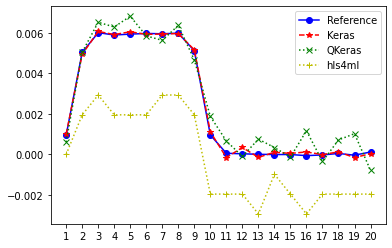

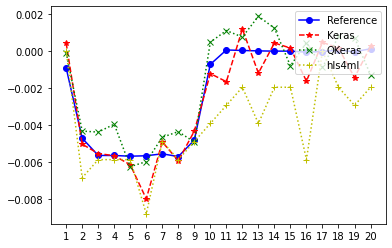

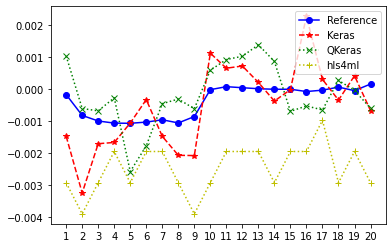

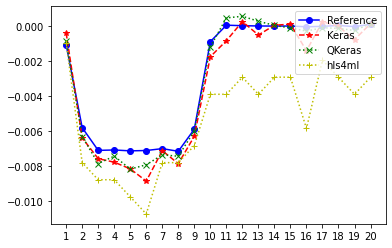

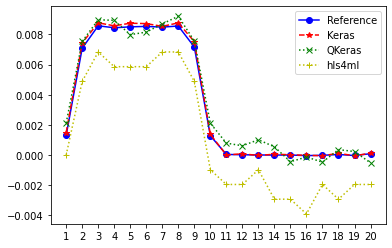

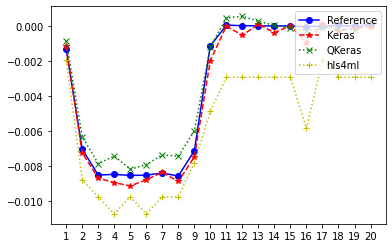

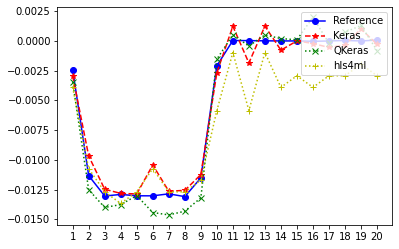

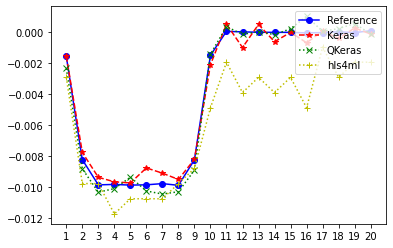

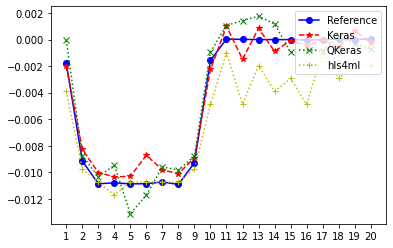

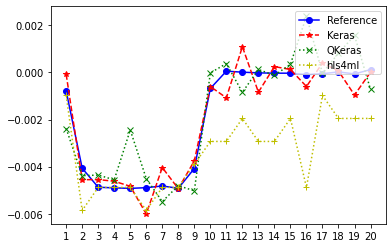

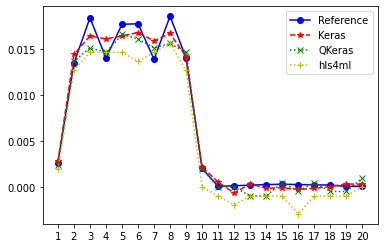

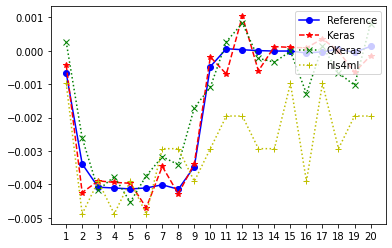

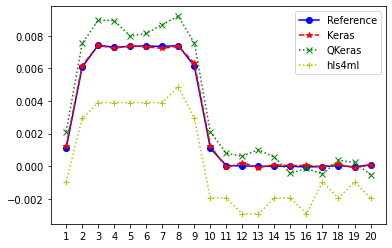

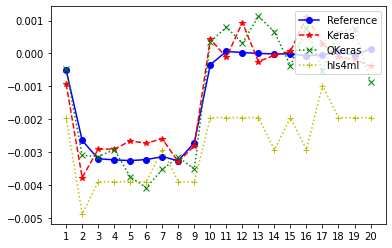

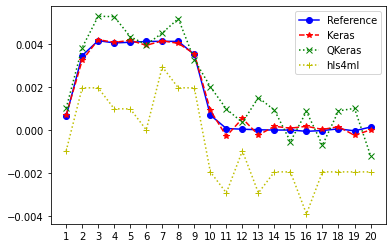

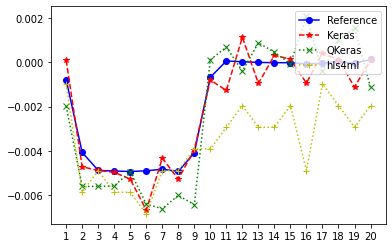

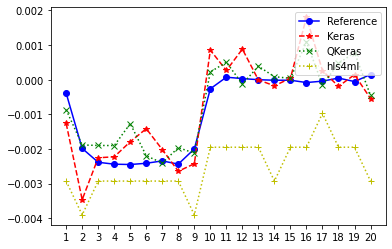

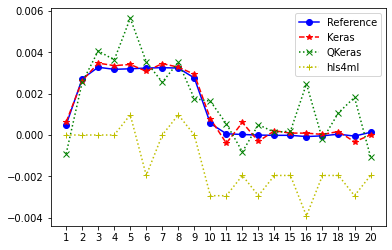

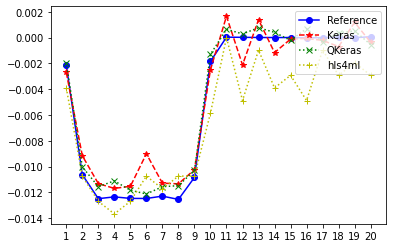

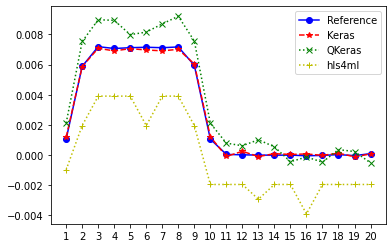

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.arange(1, 21, 1)
for i in range(20):
    plt.clf()
    plt.plot(x, Y_test[i], marker='o', linestyle='-', color='b') 
    plt.plot(x, Y_keras[i], marker='*', linestyle='--', color='r')
    plt.plot(x, Y_qkeras[i], marker='x', linestyle=':', color='g')
    plt.plot(x, Y_hls[i], marker='+', linestyle=':', color='y')
    plt.xticks(x, x)
    plt.legend(['Reference', 'Keras', 'QKeras', 'hls4ml'], loc='upper right')
    plt.show()

## Save traces

In [25]:
# For each beta, output a file with:
# - Predicted alpha
# - Beta value
# - Training set alpha
for i in range(len(x_test)):
    predicted = hmodel.predict(np.ascontiguousarray(x_test[i])).tolist()
    beta = x_test[i]
    real = list(Y_test[i])
    out_arr = predicted + [beta] + real + [""]
    out_arr = [str(x) for x in out_arr]
    print("\n".join(out_arr))
    assert(len(out_arr) == 20+1+20+1)
    with open("../scratch/hls-outputs/tfout_" + str(i) + ".txt", "w") as f:
        f.write("\n".join(out_arr))

0.0
0.001953125
0.0029296875
0.001953125
0.001953125
0.001953125
0.0029296875
0.0029296875
0.001953125
-0.001953125
-0.001953125
-0.001953125
-0.0029296875
-0.0009765625
-0.001953125
-0.0029296875
-0.001953125
-0.001953125
-0.001953125
-0.001953125
1.1309733552923256
0.0009512783569326
0.0050280687190382
0.0060014669398627
0.0058863248246369
0.0059296441250641
0.0059636985444819
0.0059473071431616
0.0059785542550266
0.0051097829701392
0.000959901769976
5.8095330638332e-05
3.2907318183444e-05
9.0083591575858e-06
-3.8176021208962e-06
-2.9657581144032e-06
-5.7563257796499e-05
-2.4152833659524e-05
4.9659281210954e-05
-3.6019635365913e-05
0.0001220264184713

0.0
-0.0068359375
-0.005859375
-0.005859375
-0.005859375
-0.0087890625
-0.0048828125
-0.005859375
-0.0048828125
-0.00390625
-0.0029296875
-0.001953125
-0.00390625
-0.001953125
-0.001953125
-0.005859375
0.0
-0.001953125
-0.0029296875
-0.001953125
-1.0681415022205298
-0.0009115793922169
-0.0047034535531814
-0.0056327830049958
-0.005636107